In [1]:
import os
from datasets import load_dataset
from sklearn.neighbors import KNeighborsRegressor
import re

from dotenv import load_dotenv
load_dotenv("../.env")


/Users/maykcaldas/miniconda3/envs/mapi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
dataset=load_dataset('ur-whitelab/mapi', token=os.environ['HF_TOKEN'])

target = ["band_gap"]
features=['nsites', 'nelements', 'formula_pretty', 'chemsys', 'volume', 'density', 'density_atomic', 'crystal_system', 'symbol', 'number', 'point_group']

train_dataset = dataset['train'].select_columns(features+target).to_pandas()
test_dataset = dataset['test'].select_columns(features+target).to_pandas()

In [3]:
def expand_formula(formula):
    # Pattern to identify groups in parentheses with their multipliers
    parenthetical_group_pattern = re.compile(r"\(([\w]+)\)(\d+)")
    match = parenthetical_group_pattern.search(formula)
    while match:
        # Extract the matched group and multiplier
        group, multiplier = match.group(1), int(match.group(2))
        # Expand the group by repeating the sequence inside the parentheses
        expanded_group = ''
        inner_matches = re.findall(r"([A-Z][a-z]*)(\d*)", group)
        for elem, qty in inner_matches:
            if qty == '':
                qty = 1
            else:
                qty = int(qty)
            expanded_group += f"{elem}{qty * multiplier}"
        # Replace the original matched pattern with its expansion
        formula = formula[:match.start()] + expanded_group + formula[match.end():]
        # Search for the next match
        match = parenthetical_group_pattern.search(formula)
    return formula

def parse_formula(formula):
    # Expand the formula first
    expanded_formula = expand_formula(formula)
    # Now parse the expanded formula
    element_pattern = re.compile(r"([A-Z][a-z]*)(\d*)")
    matches = element_pattern.findall(expanded_formula)
    # Convert counts to integers, defaulting to 1 if absent
    parsed_matches = [(elem, int(qty) if qty else 1) for elem, qty in matches]
    # Simplify the representation by aggregating counts for each element
    composition = {}
    for element, count in parsed_matches:
        if element in composition:
            composition[element] += count
        else:
            composition[element] = count
    # Prepare the final aggregated result
    aggregated_matches = [(element, str(count)) for element, count in composition.items()]
    return expanded_formula, aggregated_matches

def make_set(serie):
    all = "-".join(serie.to_list())
    all = all.split("-")
    print(set(all))

In [4]:
print(train_dataset.columns)
print(train_dataset.iloc[0])

formula = train_dataset.iloc[0]['formula_pretty']
all_elements = "-".join(train_dataset['chemsys'].to_list())
all_elements = set(all_elements.split("-"))
elements_dics = {k: v for (v, k) in enumerate(all_elements, 1)}

all_crystal = set(train_dataset['crystal_system'].to_list())
crystal_dict = {k: v for (v, k) in enumerate(all_crystal, 1)}

all_symbols = set(train_dataset['symbol'].to_list())
symbols_dict = {k: v for (v, k) in enumerate(all_symbols, 1)}

all_pgs = set(train_dataset['point_group'].to_list())
pgs_dict = {k: v for (v, k) in enumerate(all_pgs, 1)}

# map all entries in colum poing_group to a number using the dictionary
train_dataset['point_group'] = train_dataset['point_group'].map(pgs_dict)
train_dataset['symbol'] = train_dataset['symbol'].map(symbols_dict)
train_dataset['crystal_system'] = train_dataset['crystal_system'].map(crystal_dict)
for i, r in train_dataset.iterrows():
    formula, elements = parse_formula(r['formula_pretty'])
    for e in elements:
        train_dataset.at[i, e[0]] = int(e[1])

train_dataset.drop(columns=['formula_pretty', 'chemsys'], inplace=True)
train_dataset.dropna(axis=0, how='any', inplace=True, subset=target)
train_dataset = train_dataset.fillna(0)
train_dataset

Index(['nsites', 'nelements', 'formula_pretty', 'chemsys', 'volume', 'density',
       'density_atomic', 'crystal_system', 'symbol', 'number', 'point_group',
       'band_gap'],
      dtype='object')
nsites                        54
nelements                      5
formula_pretty    K2LaTa6(Br5O)3
chemsys             Br-K-La-O-Ta
volume               1442.071056
density                 5.871127
density_atomic          26.70502
crystal_system          Trigonal
symbol                     P-31c
number                       163
point_group                  -3m
band_gap                  1.1473
Name: 0, dtype: object


,nsites,nelements,volume,density,density_atomic,crystal_system,symbol,number,point_group,band_gap,...,Th,Tc,Pa,Np,Kr,Ac,Xe,He,Ar,Ne
0,54,5,1442.071056,5.871127,26.705020,6,40,163,30,1.1473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36,3,553.528617,14.666611,15.375795,4,36,189,9,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,3,702.992001,0.686733,175.748000,7,201,71,7,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,3,55.039555,1.141404,9.173259,3,99,216,18,6.5874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2,111.064085,9.283755,27.766021,1,127,139,11,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124283,10,3,167.465476,6.843615,16.746548,1,188,140,11,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124284,27,5,613.368626,6.198274,22.717357,2,150,1,2,1.9338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124285,14,3,134.119594,4.675201,9.579971,6,82,160,1,0.5920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124286,30,3,304.317682,4.022280,10.143923,5,115,12,24,0.5093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test_dataset['point_group'] = test_dataset['point_group'].map(pgs_dict)
test_dataset['symbol'] = test_dataset['symbol'].map(symbols_dict)
test_dataset['crystal_system'] = test_dataset['crystal_system'].map(crystal_dict)
for new_c in train_dataset.columns[10:]:
    test_dataset[new_c] = 0

for i, r in test_dataset.iterrows():
    formula, elements = parse_formula(r['formula_pretty'])
    for e in elements:
        test_dataset.at[i, e[0]] = int(e[1])

test_dataset.drop(columns=['formula_pretty', 'chemsys'], inplace=True)
test_dataset.dropna(axis=0, how='any', inplace=True, subset=target)
test_dataset = test_dataset.fillna(0)
test_dataset

,nsites,nelements,volume,density,density_atomic,crystal_system,symbol,number,point_group,band_gap,...,Th,Tc,Pa,Np,Kr,Ac,Xe,He,Ar,Ne
0,14,4,287.723816,4.586333,20.551701,6,1,166,30,0.0000,...,0,0,0,0,0,0,0,0,0,0
1,114,5,1605.424402,2.978140,14.082670,2,150,1,2,3.8216,...,0,0,0,0,0,0,0,0,0,0
2,40,6,509.156250,3.268359,12.728906,2,114,2,24,2.0588,...,0,0,0,0,0,0,0,0,0,0
3,12,3,135.080367,2.464534,11.256697,4,120,191,20,0.0000,...,0,0,0,0,0,0,0,0,0,0
4,14,3,190.357242,5.163406,13.596946,5,115,12,4,0.0000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31068,36,3,587.443933,4.254473,16.317887,5,84,14,4,3.6927,...,0,0,0,0,0,0,0,0,0,0
31069,14,4,224.587125,5.474862,16.041937,6,82,160,1,0.0485,...,0,0,0,0,0,0,0,0,0,0
31070,14,3,146.879212,5.226918,10.491372,7,190,63,7,0.0000,...,0,0,0,0,0,0,0,0,0,0
31071,29,3,587.261757,2.060350,20.250405,6,82,160,1,0.0000,...,0,0,0,0,0,0,0,0,0,0


In [6]:
features = [f for f in features if f not in ['formula_pretty', 'chemsys']]
model = KNeighborsRegressor(n_neighbors=10)
model.fit(train_dataset.drop(target, axis=1), train_dataset[target])
print(model.score(test_dataset.drop(target, axis=1), test_dataset[target]))


0.2919239302554062


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import matplotlib as mpl
import matplotlib.font_manager as font_manager
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True
           })

In [11]:
k=8

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

yhat=[]
y=[]
for k in range(100):
    try:
        y.append(test_dataset.iloc[k][target])
        yhat.append(model.predict(test_dataset.drop(target, axis=1).iloc[[k]]))
    except Exception as e:
        print(f"Error at index {k}: {e}")


y = np.array(y).flatten()
yhat = np.array(yhat).flatten()
print(y.shape, yhat.shape)

(100,) (100,)


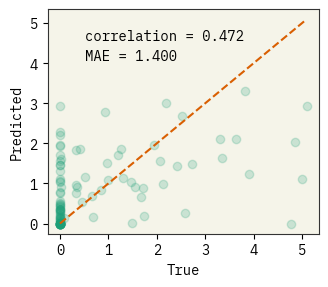

In [12]:
lim = (min(y),max(y))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(y, yhat, 'o', alpha=0.2)
plt.plot(lim, lim, '--')
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, yhat)[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_squared_error(y, yhat):.3f}")
plt.show()
